# Teleportation

Quantum information cannot be copied due to the *No Cloning Theorem*, however it can be "teleported" in the sense that a qubit can be entangled with a quantum resource, and via a protocol of measurements and *classical communication* of their results, the original quantum state can be reconstructed on a different qubit. This process destroys the information in the original qubit via measurement.

We will construct a particular qubit state and then transfer that state to another qubit using the teleportation protocol. 
---
<span style="color:red">*For visualisation, uncomment .draw()*<span>

In [6]:
from qiskit.circuit import ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator, Sampler
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit

import numpy as np
import matplotlib.pyplot as plt


We will define an angle $\theta$ to rotate our qubit by. This will allow us to easily make comparisons for the original state and the teleported state.

In [8]:
theta = Parameter('θ')

qr = QuantumRegister(1, 'q')
qc = QuantumCircuit(qr)
qc.ry(theta, 0)
#qc.draw('mpl')

Participant A (Alice) possesses the quantum information $|\psi\rangle$ in the state of $q$ and wishes to transfer it to participant B (Bob). The resource they share is a maximallyt entangled state called a Bell state
$$
|\Phi^+\rangle = \frac{1}{2} \left( |00\rangle + |11\rangle \right)
$$
with the first of the pair going to Alice and the second to Bob. Hence Alice has a 2-qubit register ($q$ and $Bell_0$) and Bob has a single-qubit register ($Bell_1$). We will construct now:

In [10]:
tele_qc = qc.copy()
bell = QuantumRegister(2, 'Bell')
alice = ClassicalRegister(2, 'Alice')
bob = ClassicalRegister(1, 'Bob')
tele_qc.add_register(bell, alice, bob)
#tele_qc.draw('mpl')

Now create the Bell pair with $Bell_0$ going to Alice and $Bell_1$ going to Bob. This is done by using a Hadamard gate to put $Bell_0$ in the $|+\rangle$ state and then performing a CNOT with the same qubit as the control.

In [12]:
# create Bell state with other two qubits
tele_qc.barrier()
tele_qc.h(1)
tele_qc.cx(1, 2)
tele_qc.barrier()
#tele_qc.draw('mpl')

Next, Alice performs a CNOT controlled by $q$ on $Bell_0$, which maps information about the state onto it. She then applies a Hadamard gate on $q$.

In [14]:
# alice operates on her qubits
tele_qc.cx(0, 1)
tele_qc.h(0)
tele_qc.barrier()
#tele_qc.draw('mpl')

Now Alice measures her qubits and saves the results to her register.

In [16]:
tele_qc.measure([qr[0], bell[0]], alice)
#tele_qc.draw('mpl')

Bob's qubit now has the information $|\psi\rangle$ from Alice's qubit $q$ encoded in $Bell_1$, but he does not know what basis to measure in to extract it. Accordingly, Alice must share the information in her register over a *classical* communication channel (this is why teleportation does not violate special relativity, no matter how far Alice and Bob are apart). She instructs Bob to perform an X gate on his qubit if her measurement of $Bell_0$ yields a 1 outcome, followed by a Z gate if her measurement of $q$ yields a 1.

In [18]:
graded_qc = tele_qc.copy()

graded_qc.x(bell[1]).c_if(alice[1], 1)
graded_qc.z(bell[1]).c_if(alice[0], 1)

#graded_qc.draw('mpl')

Finally, Bob can measure his qubit, which would yield results with the same probabilities as had Alice measured it originally.

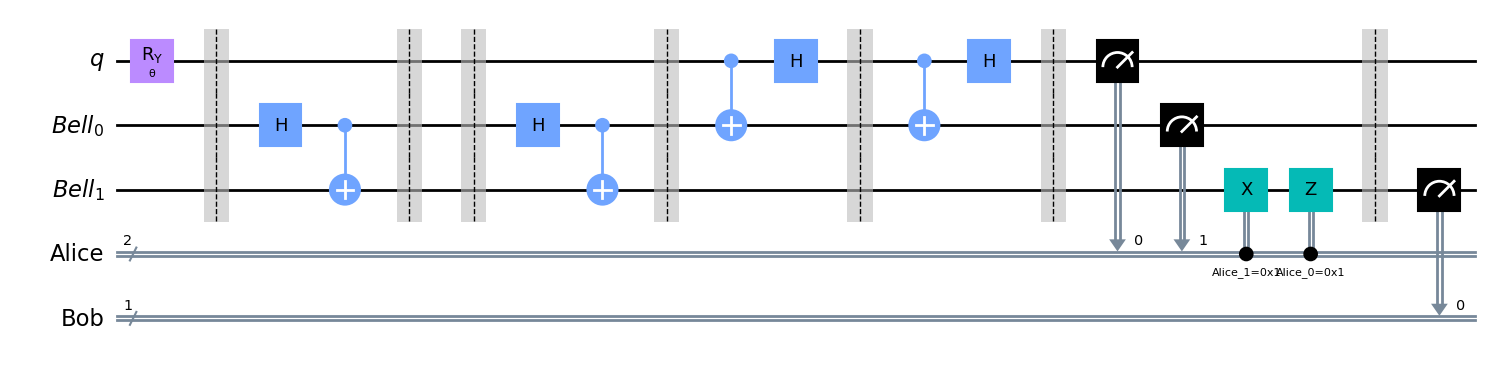

In [19]:
graded_qc.barrier()
graded_qc.measure(bell[1], bob)
graded_qc.draw('mpl')

After building the quantum circuit, we will pass inour angle and run the measurement:

In [21]:
angle = 5*np.pi/7

sampler = Sampler()
qc.measure_all()
job_static = sampler.run(qc.bind_parameters({theta: angle}))
job_dynamic = sampler.run(graded_qc.bind_parameters({theta: angle}))

print(f"Original Dists: {job_static.result().quasi_dists[0].binary_probabilities()}")
print(f"Teleported Dists: {job_dynamic.result().quasi_dists[0].binary_probabilities()}")

Original Dists: {'0': 0.1882550990706333, '1': 0.8117449009293668}
Teleported Dists: {'000': 0.0470637747676583, '001': 0.2029362252323416, '010': 0.0470637747676583, '011': 0.2029362252323416, '100': 0.2029362252323416, '101': 0.0470637747676583, '110': 0.2029362252323416, '111': 0.0470637747676583}


We can see that by doing this measurement we obtained both Alices and Bob's result. We need to "trim down" the obtained array:

In [22]:
from qiskit.result import marginal_counts

result = job_dynamic.result().quasi_dists[0].binary_probabilities()

tele_counts = marginal_counts(result, [2])

And finally, we can compare: theprobabilites that Allice woudl have measured on *q* at the beginning of the circuit, and the measures Bob obtained at the end:

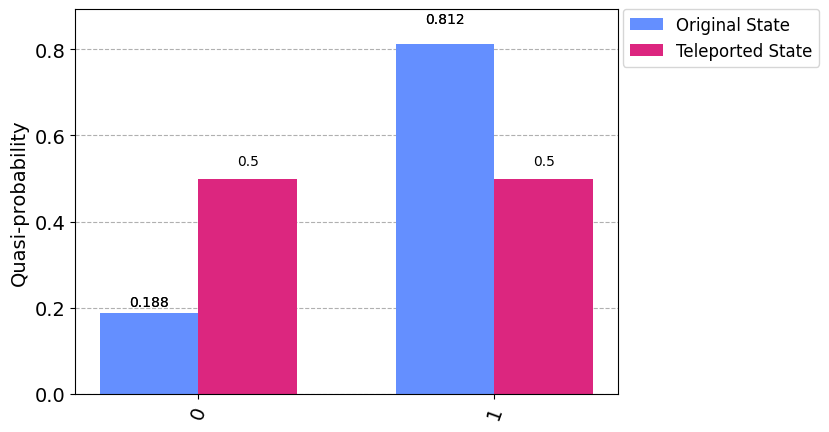

In [23]:
legend = ['Original State', 'Teleported State']
plot_histogram([job_static.result().quasi_dists[0].binary_probabilities(), tele_counts], legend=legend)